In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_loader, test_loader = mnist()

In [3]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        innerLayerShape1 = 128
        self.fc1 = nn.Linear(28*28, innerLayerShape1)
        self.fc2 = nn.Linear(innerLayerShape1, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_loss = [0]*len(models)
    train_loss_count = [0]*len(models)
    for batch_idx, (data, target) in enumerate(train_loader):
        for m_idx, model in enumerate(models):
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            train_loss[m_idx] += model._loss.item()
            train_loss_count[m_idx] += 1
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            lossesArr = []
            for i, m in enumerate(models):
                lossModel = m._loss.item()
                lossesArr.append('{}: {:.6f}'.format(i, lossModel))
            losses = ' '.join(lossesArr)
            print(line + losses)
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        lossesArr = []
        for i, m in enumerate(models):
            lossModel = m._loss.item()
            lossesArr.append('{}: {:.6f}'.format(i, lossModel))
        losses = ' '.join(lossesArr)
        print(line + losses)
    for i in range(len(models)):
        train_loss[i] /= train_loss_count[i]
        print('Loss {}: {:.4f}'.format(i, train_loss[i]))
    return train_loss

In [5]:
models = [Net(), Net(True)]

In [6]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models):
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in test_loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, reduction='sum').item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= len(test_loader.dataset)
    correct_pct = [100. * c / len(test_loader.dataset) for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss

In [7]:
count_epoch = 15
train_losses = [[0.0] * count_epoch for i in range(len(models))]
test_losses = [[0.0] * count_epoch for i in range(len(models))]
for epoch in range(count_epoch):
    train_loss = train(epoch+1, models)
    test_loss = test(models)
    for i in range(len(models)):
        train_losses[i][epoch] = train_loss[i]
        test_losses[i][epoch] = test_loss[i]

Train Epoch: 1 [0/60000 (0%)]	Losses 0: 2.424523 1: 2.305006
Train Epoch: 1 [10000/60000 (17%)]	Losses 0: 0.234919 1: 0.270151
Train Epoch: 1 [20000/60000 (33%)]	Losses 0: 0.323642 1: 0.244913
Train Epoch: 1 [30000/60000 (50%)]	Losses 0: 0.127554 1: 0.142278
Train Epoch: 1 [40000/60000 (67%)]	Losses 0: 0.107761 1: 0.101978
Train Epoch: 1 [50000/60000 (83%)]	Losses 0: 0.257500 1: 0.201109
Train Epoch: 1 [60000/60000 (100%)]	Losses 0: 0.042087 1: 0.044728
Loss 0: 0.2463
Loss 1: 0.2474
Test set:
0: Loss: 0.1355	Accuracy: 9593/10000 (96%)
1: Loss: 0.1314	Accuracy: 9604/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Losses 0: 0.110392 1: 0.090640
Train Epoch: 2 [10000/60000 (17%)]	Losses 0: 0.036408 1: 0.027049
Train Epoch: 2 [20000/60000 (33%)]	Losses 0: 0.067190 1: 0.171259
Train Epoch: 2 [30000/60000 (50%)]	Losses 0: 0.108034 1: 0.120345
Train Epoch: 2 [40000/60000 (67%)]	Losses 0: 0.168549 1: 0.193421
Train Epoch: 2 [50000/60000 (83%)]	Losses 0: 0.139388 1: 0.080231
Train Epoch: 2 [60000/60

Train Epoch: 15 [10000/60000 (17%)]	Losses 0: 0.002730 1: 0.002466
Train Epoch: 15 [20000/60000 (33%)]	Losses 0: 0.001456 1: 0.003419
Train Epoch: 15 [30000/60000 (50%)]	Losses 0: 0.001854 1: 0.002626
Train Epoch: 15 [40000/60000 (67%)]	Losses 0: 0.003075 1: 0.002205
Train Epoch: 15 [50000/60000 (83%)]	Losses 0: 0.001872 1: 0.001115
Train Epoch: 15 [60000/60000 (100%)]	Losses 0: 0.008511 1: 0.014673
Loss 0: 0.0027
Loss 1: 0.0032
Test set:
0: Loss: 0.0805	Accuracy: 9790/10000 (98%)
1: Loss: 0.0720	Accuracy: 9783/10000 (98%)



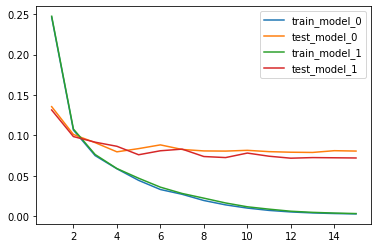

In [8]:
x_scale = [x for x in range(1,count_epoch+1)]
plt.plot(x_scale, train_losses[0], label='train_model_0')
plt.plot(x_scale, test_losses[0], label='test_model_0')
plt.plot(x_scale, train_losses[1], label='train_model_1')
plt.plot(x_scale, test_losses[1], label='test_model_1')
plt.legend();

# 